## learning-AI : EMG classification
### EMG Physical Action Data Set을 transformer를 통한 classification

<br>

- **임규연 (lky473736)**
- 2024.09.17.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/213/emg+physical+action+data+set
- **data abstract** : The Physical Action Data Set includes 10 normal and 10 aggressive physical actions that measure the human activity. The data have been collected by 4 subjects using the Delsys EMG wireless apparatus.

------



## <span id='dl'><mark>DL</mark></span>
    
EMG Physical Action Data Set을 classification한다. transformer을 이용한다.

- **Reference**
    - https://archive.ics.uci.edu/dataset/213/emg+physical+action+data+set
    - https://www.ucihealth.org/health-library/content?contentTypeID=92&contentID=P07656&language=en
    - https://www.kaggle.com/code/durgancegaur/emg-dataset
    - https://www.kaggle.com/code/rachit2702/notebook6db9079b5a
    - https://ieeexplore.ieee.org/document/10288050/references#references
    - https://medium.com/analytics-vidhya/analysis-of-emg-physical-data-aggressive-normal-activities-4d5a696730b4
    - https://keras.io/examples/timeseries/timeseries_classification_transformer/
    - https://github.com/MyungKyuYi/HAR/blob/main/Transformer_WISDM_1204.ipynb

In [43]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout, Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply
from keras.models import Model
# objectives 작동 X -> losses로 변경
from keras.losses import mean_squared_error
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from keras.initializers import random_normal
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import Callback

from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns

In [44]:
# 데이터 준비

import glob

# data dir
directory = '../../data/EMG/EMG'

behaviors = [
    # Aggressive
    "Elbowing",
    "Frontkicking",
    "Hamering",
    "Headering",
    "Kneeing",
    "Pulling",
    "Punching",
    "Pushing",
    "Sidekicking",
    "Slapping",
    
    # Normal
    "Bowing",
    "Clapping",
    "Handshaking",
    "Hugging",
    "Jumping",
    "Running",
    "Seating",
    "Standing",
    "Walking",
    "Waving"
]

# dataframe 넣을 directory
# 이중 directory 구조, 각 행동마다에 dataframe 넣을 것
dir_df = {}
for i in range (1, 5) :
    dir_compo = {}
    for behavior in behaviors : # 행동
        dir_compo[behavior] = None
    dir_df[f'sub{i}'] = dir_compo
    
print (dir_df)

txt_files = glob.glob(os.path.join(directory, '**', '*.txt'), 
                      recursive=True) # 하위 디렉토리까지 txt 파일 찾기

# readme_file = os.path.join(directory, 'readme.txt')
# txt_files = [file for file in txt_files if file != readme_file]

# header (feature의 이름들)
muscles = [
    "R-Bic",
    "R-Tri",
    "R-Thi",
    "R-Ham",
    "L-Bic",
    "L-Tri",
    "L-Thi",
    "L-Ham"
]

# txt -> csv
for i, txt_file in enumerate(txt_files) :
    try :
        with open(txt_file, 'r') as file :
            lines = file.readlines() # 파일 읽기

        csv_file = txt_file.replace('.txt', '.csv')

        with open(csv_file, 'w', encoding='utf-8') as file :
            for line in lines : # 라인마다
                csv_line = line.strip().replace('\t', ',')
                file.write(csv_line + '\n')

        os.remove(txt_file) # 원본 삭제
        
        print(f'{txt_file} -> {csv_file} : SUCCESS')
    
        df_temp = pd.read_csv(csv_file, names=muscles)
        print (df_temp.shape)
        
        # 피실험자 번호 찾기 -> directory에 데이터프레임 넣기
        for j in range(1, 5) :
            if str(j) in csv_file :
                for behavior in behaviors :
                    if behavior in csv_file :
                        dir_df[f'sub{j}'][behavior] = df_temp
                        break
        
    except Exception as e :
        print(f"{e}")
        
    print ('\n---------------------\n')

print (dir_df)

{'sub1': {'Elbowing': None, 'Frontkicking': None, 'Hamering': None, 'Headering': None, 'Kneeing': None, 'Pulling': None, 'Punching': None, 'Pushing': None, 'Sidekicking': None, 'Slapping': None, 'Bowing': None, 'Clapping': None, 'Handshaking': None, 'Hugging': None, 'Jumping': None, 'Running': None, 'Seating': None, 'Standing': None, 'Walking': None, 'Waving': None}, 'sub2': {'Elbowing': None, 'Frontkicking': None, 'Hamering': None, 'Headering': None, 'Kneeing': None, 'Pulling': None, 'Punching': None, 'Pushing': None, 'Sidekicking': None, 'Slapping': None, 'Bowing': None, 'Clapping': None, 'Handshaking': None, 'Hugging': None, 'Jumping': None, 'Running': None, 'Seating': None, 'Standing': None, 'Walking': None, 'Waving': None}, 'sub3': {'Elbowing': None, 'Frontkicking': None, 'Hamering': None, 'Headering': None, 'Kneeing': None, 'Pulling': None, 'Punching': None, 'Pushing': None, 'Sidekicking': None, 'Slapping': None, 'Bowing': None, 'Clapping': None, 'Handshaking': None, 'Hugging': N

(9655, 8)

---------------------

../../data/EMG/EMG/sub3/Normal/txt/Seating.txt -> ../../data/EMG/EMG/sub3/Normal/txt/Seating.csv : SUCCESS
(9844, 8)

---------------------

../../data/EMG/EMG/sub3/Normal/txt/Walking.txt -> ../../data/EMG/EMG/sub3/Normal/txt/Walking.csv : SUCCESS
(10246, 8)

---------------------

../../data/EMG/EMG/sub3/Normal/txt/Hugging.txt -> ../../data/EMG/EMG/sub3/Normal/txt/Hugging.csv : SUCCESS
(9755, 8)

---------------------

../../data/EMG/EMG/sub4/Aggressive/txt/Hamering.txt -> ../../data/EMG/EMG/sub4/Aggressive/txt/Hamering.csv : SUCCESS
(9550, 8)

---------------------

../../data/EMG/EMG/sub4/Aggressive/txt/Pulling.txt -> ../../data/EMG/EMG/sub4/Aggressive/txt/Pulling.csv : SUCCESS
(10000, 8)

---------------------

../../data/EMG/EMG/sub4/Aggressive/txt/Frontkicking.txt -> ../../data/EMG/EMG/sub4/Aggressive/txt/Frontkicking.csv : SUCCESS
(9522, 8)

---------------------

../../data/EMG/EMG/sub4/Aggressive/txt/Pushing.txt -> ../../data/EMG/EMG/sub4/Aggr

In [45]:
# 모든 파일을 열어서 target 열 추가

behavior_to_index = {
    "Elbowing": 0,
    "Frontkicking": 1,
    "Hamering": 2,
    "Headering": 3,
    "Kneeing": 4,
    "Pulling": 5,
    "Punching": 6,
    "Pushing": 7,
    "Sidekicking": 8,
    "Slapping": 9,
    "Bowing": 10,
    "Clapping": 11,
    "Handshaking": 12,
    "Hugging": 13,
    "Jumping": 14,
    "Running": 15,
    "Seating": 16,
    "Standing": 17,
    "Walking": 18,
    "Waving": 19
}


for key_1 in dir_df.keys() : 
    for key_2 in dir_df[key_1].keys() : 
        dir_df[key_1][key_2]['target'] = behavior_to_index[key_2]

In [46]:
# 모든 파일의 결측치 전처리 (결측치를 평균값으로 대체)

for key_1 in dir_df.keys() : 
    for key_2 in dir_df[key_1].keys() : 
        print (dir_df[key_1][key_2].isnull().sum())
        dir_df[key_1][key_2] = dir_df[key_1][key_2].fillna(dir_df[key_1][key_2].mean())

R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi     0
R-Ham     0
L-Bic     0
L-Tri     0
L-Thi     0
L-Ham     0
target    0
dtype: int64
R-Bic     0
R-Tri     0
R-Thi   

In [47]:
# normal set, aggressive set prepare

aggressive_features = behaviors[0:10]
normal_features = behaviors[10:]

print ("normal_features : ", normal_features)
print ("aggressive_features : ", aggressive_features)

########

normal_set_sub1 = pd.concat([dir_df['sub1'][key] for key in normal_features])
print (normal_set_sub1.info())
print (normal_set_sub1.shape)

aggressive_set_sub1 = pd.concat([dir_df['sub1'][key] for key in aggressive_features])
print (aggressive_set_sub1.info())
print (aggressive_set_sub1.shape)

normal_features :  ['Bowing', 'Clapping', 'Handshaking', 'Hugging', 'Jumping', 'Running', 'Seating', 'Standing', 'Walking', 'Waving']
aggressive_features :  ['Elbowing', 'Frontkicking', 'Hamering', 'Headering', 'Kneeing', 'Pulling', 'Punching', 'Pushing', 'Sidekicking', 'Slapping']
<class 'pandas.core.frame.DataFrame'>
Index: 98886 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   R-Bic   98886 non-null  int64
 1   R-Tri   98886 non-null  int64
 2   R-Thi   98886 non-null  int64
 3   R-Ham   98886 non-null  int64
 4   L-Bic   98886 non-null  int64
 5   L-Tri   98886 non-null  int64
 6   L-Thi   98886 non-null  int64
 7   L-Ham   98886 non-null  int64
 8   target  98886 non-null  int64
dtypes: int64(9)
memory usage: 7.5 MB
None
(98886, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 98172 entries, 0 to 9787
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0  

In [48]:
# df 준비

df = pd.concat([normal_set_sub1, aggressive_set_sub1])
df.shape

(197058, 9)

In [49]:
'''
    oversampling은 함수로 구현한다. 원래는 SMOTE를 사용하려고 하였다.
    SMOTE (Synthetic Minority Over-sampling Technique)는 적은 수의 
    클래스 사이에서 새로운 가상 records를 구성하는 것이다.
    하지만, 랜덤으로 위치를 다시 uniting하기 때문에 시계열 데이터에는 적합하지 않아 직접 구현한다.
    
    여기서는 이 함수를 각 target마다의 record 수를 맞추어주기 위함으로 사용한다.
'''

def oversampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    # 리스트에 저장된 데이터프레임들을 합침
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = oversampling(df, 'target', max_size=15000)
print (df_resampled['target'].value_counts())

target
10    15000
11    15000
8     15000
7     15000
6     15000
5     15000
4     15000
3     15000
2     15000
1     15000
0     15000
19    15000
18    15000
17    15000
16    15000
15    15000
14    15000
13    15000
12    15000
9     15000
Name: count, dtype: int64


In [50]:
# split the input, target

EMG_input = df_resampled.drop(columns=['target'])
EMG_target = df_resampled['target']

print (EMG_input.head())
print (EMG_target.head())

   R-Bic  R-Tri  R-Thi  R-Ham  L-Bic  L-Tri  L-Thi  L-Ham
0    -19     11     65    290     88   -159    315    -16
1      3      6    -53     28      5   -118      9     88
2     -5    -69     44     80   4000    -90   -174    -10
3    -20    290    -19    105    462     74    193    276
4     50    -96     -8    -75  -1357    -17    628     65
0    10
1    10
2    10
3    10
4    10
Name: target, dtype: int64


In [51]:
# z-score normalization 수행

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

EMG_input_scaled = scaler.fit_transform(EMG_input)
EMG_target_reshaped = EMG_target.to_numpy().reshape(-1, 1)

# normalization된 입력 데이터와 label 데이터를 결합하여 DataFrame 생성
df = pd.DataFrame(
    np.hstack((EMG_input_scaled, EMG_target_reshaped)),
    columns=[feature for feature in muscles] + ['target']
)
df

,R-Bic,R-Tri,R-Thi,R-Ham,L-Bic,L-Tri,L-Thi,L-Ham,target
0,0.005278,0.010167,0.056287,0.346874,0.033009,-0.105683,0.125345,-0.008467,10.0
1,0.026901,0.002830,-0.036741,0.041719,-0.001220,-0.084037,-0.011801,0.049963,10.0
2,0.019038,-0.107222,0.039731,0.102284,1.646345,-0.069253,-0.093819,-0.005096,10.0
3,0.004295,0.419560,-0.009936,0.131402,0.187250,0.017334,0.070666,0.155587,10.0
4,0.073094,-0.146840,-0.001264,-0.078246,-0.562918,-0.030711,0.265629,0.037041,10.0
...,...,...,...,...,...,...,...,...,...
299995,0.536996,-0.020648,0.767401,0.311933,-0.002045,-0.874412,1.776924,-0.136564,9.0
299996,-0.727923,-0.501941,0.138278,0.013766,1.481794,0.015222,-0.254719,-0.005096,9.0
299997,0.504562,-1.891529,-0.010725,-0.439308,-1.652910,0.338342,1.776924,0.009511,9.0
299998,-0.100869,0.208260,-0.069853,0.536722,0.631412,-0.225533,0.322549,0.099404,9.0


In [52]:
'''
    시계열 데이터를 프레임 크기와 홉 크기로 분할
    일종의 split_sequence과 비슷하다고 보임
    
    아래 함수는 현재 x, y, z를 time-frame으로 split하고, hop_size가 일종의 이동량의 역할을 한다.
    최종적으로는 frames와 labels를 반환하고 있다.
    
    아래를 현재 EMG 데이터셋에 맞게끔 변형할 것이다. 다음 셀을 참고.
'''

import scipy.stats as stats

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [53]:
# def get_frames(df, frame_size, hop_size):
#     N_FEATURES = 6  # 6개의 특징 (back_x, back_y, back_z, thigh_x, thigh_y, thigh_z)

#     frames = []
#     labels = []
#     for i in range(0, len(df) - frame_size, hop_size):
#         # 각 축의 데이터를 슬라이싱
#         back_x = df['back_x'].values[i: i + frame_size]
#         back_y = df['back_y'].values[i: i + frame_size]
#         back_z = df['back_z'].values[i: i + frame_size]
#         thigh_x = df['thigh_x'].values[i: i + frame_size]
#         thigh_y = df['thigh_y'].values[i: i + frame_size]
#         thigh_z = df['thigh_z'].values[i: i + frame_size]

#         # 해당 구간의 레이블에서 가장 많이 나타나는 레이블 선택
#         mode_result = stats.mode(df['label'][i: i + frame_size])
#         label = mode_result.mode[0]  # mode_result.mode는 배열이므로 첫 번째 값을 선택

#         # 각 축의 데이터를 하나의 리스트로 묶어 프레임에 추가
#         frames.append([back_x, back_y, back_z, thigh_x, thigh_y, thigh_z])
#         labels.append(label)

#     # 프레임을 numpy 배열로 변환하고, (number_of_frames, frame_size, N_FEATURES) 형태로 reshape
#     frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
#     labels = np.asarray(labels)

#     return frames, labels

def get_frames(df, frame_size, hop_size) :
    N_FEATURES = 8  # attribute 8개
    frames = []
    labels = []
    
    for i in range(0, len(df) - frame_size + 1, hop_size) :
        r_bic = df['R-Bic'].values[i: i + frame_size]
        r_tri = df['R-Tri'].values[i: i + frame_size]
        r_thi = df['R-Thi'].values[i: i + frame_size]
        r_ham = df['R-Ham'].values[i: i + frame_size]
        l_bic = df['L-Bic'].values[i: i + frame_size]
        l_tri = df['L-Tri'].values[i: i + frame_size]
        l_thi = df['L-Thi'].values[i: i + frame_size]
        l_ham = df['L-Ham'].values[i: i + frame_size]

        mode_result = stats.mode(df['target'][i: i + frame_size], keepdims=False) # 가장 많이 빈출하는 값 찾기
        
        # 디버깅 정보 출력
        print (f"Mode Result: {mode_result}")

        '''
            여기서 mode_result가 scala값이라서 오류가 발생하는 경우가 생김
            따라서 여기서 isinstance로 타입 확인하고 그에 따라서 대처함
        '''
        if isinstance(mode_result.mode, np.ndarray) : # 만약 mode 결과가 스칼라인 경우 처리
            if mode_result.mode.size > 0 :
                label = mode_result.mode[0]
            else:
                label = -1
        else :
            label = mode_result.mode  # 스칼라일 경우 직접 사용

        # 각 축을 묶어서 데이터 추가함
        frames.append([r_bic, r_tri, r_thi, r_ham, l_bic, l_tri, l_thi, l_ham])
        labels.append(label)

    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES) # reshape
    labels = np.asarray(labels)

    return frames, labels


In [54]:
# input, target split

Fs = 1000
frame_size = Fs * 5
hop_size = Fs * 1

EMG_input, EMG_target = get_frames(df, frame_size, hop_size)

Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=5000)
Mode Result: ModeResult(mode=10.0, count=4000)
Mode Result: ModeResult(mode=10.0, count=3000)
Mode Result: ModeResult(mode=11.0, count=3000)
Mode Result: ModeResult(mode=11.0, count=4000)
Mode Result: ModeResult(mode=11.0, count=5000)
Mode Result: ModeResult(mode=11.0, count=5000)
Mode Result: ModeResult(mode=11.0, count=5000)
Mode Result: ModeResult(mode=11.0, count=5000)
Mode Result: ModeResult(mode=11.0, count=5000)
Mode Result: ModeResult(mode=11.0, count=5000)
Mode Result: 

Mode Result: ModeResult(mode=4.0, count=3000)
Mode Result: ModeResult(mode=4.0, count=4000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=5000)
Mode Result: ModeResult(mode=4.0, count=4000)
Mode Result: ModeResult(mode=4.0, count=3000)
Mode Result: ModeResult(mode=5.0, count=3000)
Mode Result: ModeResult(mode=5.0, count=4000)
Mode Result: ModeResult(mode=5.0, count=5000)
Mode Result: ModeResult(mode=5.0, count=5000)
Mode Result: ModeResult(mode=5.0, count=5000)
Mode Result: ModeResult(mode=5.0, count=5000)
Mode Result: ModeResult(mode=5.0, 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(EMG_input, EMG_target, 
                                                    test_size = 0.1,
                                                    stratify = EMG_target)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((266, 5000, 8), (266,), (30, 5000, 8), (30,))

In [56]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [57]:
"""
    The main part of our model is now complete. We can stack multiple of those
    `transformer_encoder` blocks and we can also proceed to add the final
    Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
    layers, we need to reduce the output tensor of the `TransformerEncoder` part of
    our model down to a vector of features for each data point in the current
    batch. A common way to achieve this is to use a pooling layer. For
    this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(len(df['target'].unique()), activation="softmax")(x) # label
    return keras.Model(inputs, outputs)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 5000, 8)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5000, 8)   │     35,848 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 5000, 8)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5000, 8)   │         16 │ dropout_27[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 5000, 8)   │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 5000, 4)   │         36 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 5000, 4)   │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 5000, 8)   │         40 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5000, 8)   │         16 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 5000, 8)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5000, 8)   │     35,848 │ add_17[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 5000, 8)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5000, 8)   │         16 │ dropout_30[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 5000, 8)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 5000, 4)   │         36 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 5000, 4)   │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 5000, 8)   │         40 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5000, 8)   │         16 │ conv1d_19[0][0]   │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 786,532 (3.00 MB)

 Trainable params: 786,532 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

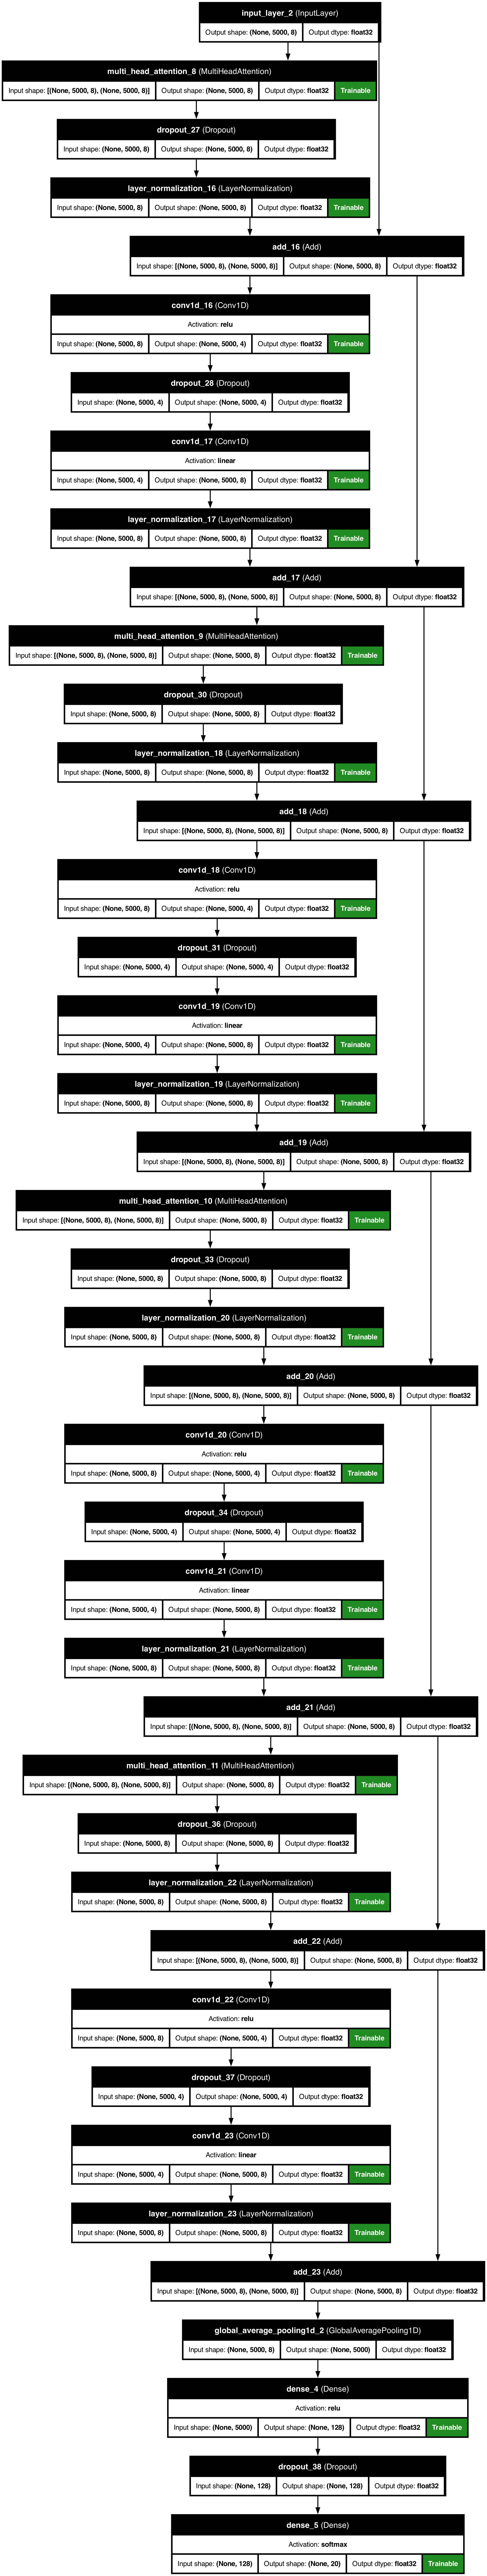

In [58]:
# modelling

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

input_shape = (frame_size, 8)

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.summary()
keras.utils.plot_model(model, 
                      show_dtype=True,
                      show_layer_activations=True,
                      show_layer_names=True,
                      show_shapes=True,
                      show_trainable=True)

In [59]:
# compile

model.compile(
    loss="sparse_categorical_crossentropy",
    #loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    #metrics=["sparse_categorical_accuracy"],
    metrics=["accuracy"],
)

In [ ]:
# fit 
# memory 문제가 일어날 수 있기 때문에 memory_profiler 도입

from memory_profiler import profile

callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model() :
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        callbacks=callbacks,
    )
    
    return history

history = train_model()

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_5876/3341657725.py
Epoch 1/50


In [ ]:
# evaluate

model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [ ]:
# acc 시각화

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.legend (['train acc', 'validation acc'])
plt.show() 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = model.predict(X_test)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - test set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()